# Table of Contents
1. [Imports](#Imports)
2. [Load Data](#load_data)
4. [ML Pipeline](#ml_pipeline)
   - [Split Data (Testing, Training Data Sets)](#split_data)
   - [Set Window Length](#win_len_metrics)
   - [Fill Training, Test Data](#fill_training_test)
   - [Load Model](#load_model)
   - [Train Model](#train_model)
   - [Graph Predicted Values with Training Set](#graph_pred_training_set)
   - [Graph Predicted Values with Test Data](#graph_pred_test_set)

### <a name="imports"></a>Imports

In [3]:
import matplotlib.pyplot as plt
from datetime import timedelta
import pandas as pd
import numpy as np
import datetime
import time

from_date="2013-04-28"
to_date="2018-10-01"
pd.set_option('display.expand_frame_repr', False)


### <a name="load_data"></a>Load Data

In [4]:
model_data = pd.read_csv('model_data.csv').iloc[:, 1:]
# Fillimisht i kthej ne rend zbrites te dhenat
model_data = model_data.assign(date=pd.to_datetime(model_data['date']))
model_data = model_data.sort_values(by='date')
model_data

In [3]:
model_data.head()
model_data.isnull().values.any()

False

In [4]:
model_data = model_data[model_data['date']>="2016-01-01"]

#### <a name="split_data"></a>Split Data (Testing, Training Data Sets)

In [6]:
split_date='2018-04-25'
# Heq kolonen e dates meqe nuk na duhet me
training_set, test_set = model_data[model_data['date']<split_date], model_data[model_data['date']>=split_date]
training_set = training_set.drop('date', 1)
test_set = test_set.drop('date', 1)

In [30]:
# print(len(training_set))
# print(len(test_set)) 
# print(len(model_data))

In [8]:
import plotly.plotly as py
import plotly.graph_objs as go

import pandas as pd

training = go.Scatter(
                x=model_data[model_data['date'] < split_date]['date'].astype(datetime.datetime),
                y=model_data[model_data['date'] < split_date]['btc_close'],
                name = "Trajnim",
                line = dict(color = '#6D13C1'),
                opacity = 0.8)

test = go.Scatter(
                x=model_data[model_data['date'] >= split_date]['date'].astype(datetime.datetime),
                y=model_data[model_data['date'] >= split_date]['btc_close'],
                name = "Testim",
                line = dict(color = '#17BECF'),
                opacity = 0.8)


data = [training, test]

layout = dict(
    title = "Ndarja e te dhenave ne bashkesi per trajnim (80%) dhe testim (20%) ",
    xaxis = dict(
        range = ['2016-01-01','2018-10-30']),
     yaxis=dict(
        title='Cmimi Normalizuar i Bitcoin')
)

fig = dict(data=data, layout=layout)
py.iplot(fig, filename = "Manually Set Range")

#### <a name="win_len_metrics"></a>Set Window Length

In [9]:
window_len=32
pred_range=30 

training_inputs = []
for i in range(len(training_set)-window_len):
    temp_set = training_set[i:(i+window_len)].copy()
    training_inputs.append(temp_set)   

#### <a name="fill_training_test"></a>Fill Training, Test Data

In [11]:
test_inputs = []
for i in range(len(test_set)-window_len):
    temp_set = test_set[i:(i+window_len)].copy()
    test_inputs.append(temp_set)

# print(test_inputs[0])
test_outputs = test_set['btc_close'][window_len:].values
print(len(test_outputs)) # predicting 45 points in the future

157


In [12]:
training_inputs = [np.array(training_inputs) for training_inputs in training_inputs]
training_inputs = np.array(training_inputs)

test_inputs = [np.array(test_inputs) for test_inputs in test_inputs]
test_inputs = np.array(test_inputs)

In [13]:
training_outputs = []
for i in range(window_len, len(training_set['btc_close'])-pred_range):
    training_outputs.append(training_set['btc_close'][i:i+pred_range].values)
    
training_outputs = np.array(training_outputs)

# testing outputs, which is needed to evaluate/predict the model
testing_outputs = []
for i in range(window_len, len(test_set['btc_close'])-pred_range):
    testing_outputs.append(test_set['btc_close'][i:i+pred_range].values)

testing_outputs = np.array(testing_outputs)


In [14]:
print(training_inputs.shape)
print(training_outputs.shape)

print(test_inputs.shape)
print(testing_outputs.shape)

(813, 32, 11)
(783, 30)
(157, 32, 11)
(127, 30)


#### <a name="load_model"></a>Load Model

In [32]:
# import Keras modules
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout

def lstm_model(inputs, output_size, neurons, activ_func="relu",
                dropout=0.25, loss="mae", optimizer="adam"):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation("linear"))

    model.compile(loss=loss, optimizer=optimizer)
    return model

#### <a name="train_model"></a>Train Model

In [16]:
# random seed for reproducibility
np.random.seed(202)

# initialise model architecture
bt_model = lstm_model(training_inputs, output_size=pred_range, neurons = 100)
# bt_model = denser_model(LSTM_training_inputs, output_size=pred_range, neurons = 100)

# print(bt_model.get_weights())
# train model on data
bt_history = bt_model.fit(training_inputs[:-pred_range], training_outputs, 
                            epochs=100, batch_size=32, verbose=1, shuffle=True)

loss_fn=str(np.mean(bt_history.history['loss']))

Epoch 1/100
783/783 [==============================] - 1s 1ms/step - loss: 0.1000
Epoch 2/100
783/783 [==============================] - 0s 528us/step - loss: 0.0559
Epoch 3/100
783/783 [==============================] - 0s 513us/step - loss: 0.0474
Epoch 4/100
783/783 [==============================] - 0s 502us/step - loss: 0.0420
Epoch 5/100
783/783 [==============================] - 0s 502us/step - loss: 0.0405
Epoch 6/100
783/783 [==============================] - 0s 511us/step - loss: 0.0381
Epoch 7/100
783/783 [==============================] - 0s 529us/step - loss: 0.0352
Epoch 8/100
783/783 [==============================] - 0s 515us/step - loss: 0.0344
Epoch 9/100
783/783 [==============================] - 0s 507us/step - loss: 0.0333
Epoch 10/100
783/783 [==============================] - 0s 510us/step - loss: 0.0315
Epoch 11/100
783/783 [==============================] - 0s 550us/step - loss: 0.0317
Epoch 12/100
783/783 [==============================] - 0s 563us/step - loss

In [17]:
from ann_visualizer.visualize import ann_viz;
from keras.utils.vis_utils import plot_model
graph = plot_model(bt_model, to_file="my_model.png", show_shapes=True)

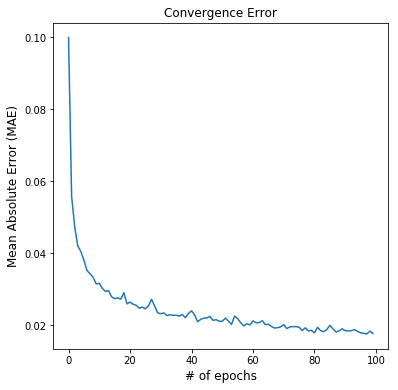

'mae'

In [33]:
from pylab import rcParams
rcParams['figure.figsize'] = 6, 6

# fig.clear()
fig, ax1 = plt.subplots(1,1)

ax1.plot(bt_history.epoch, bt_history.history['loss'])
ax1.set_title('Convergence Error')

if bt_model.loss == 'mae':
    ax1.set_ylabel('Mean Absolute Error (MAE)',fontsize=12)
# just in case you decided to change the model loss calculation
else:
    ax1.set_ylabel('Model Loss',fontsize=12)
ax1.set_xlabel('# of epochs',fontsize=12)
plt.show()
bt_model.loss

In [19]:
import sklearn.metrics

# From History though: 
print("From Training History: " + str(np.mean(bt_history.history['loss'])) )

a=bt_model.predict(training_inputs[:-pred_range])

print( "Scikit: " + str(sklearn.metrics.mean_absolute_error(training_outputs, bt_model.predict(training_inputs[:-pred_range]))))

print('Mean from Prediction: %.4f'%np.mean(np.abs((bt_model.predict(training_inputs[:-pred_range]))-\
            (training_outputs))))

# print('MAE: %.4f'%np.mean(np.abs((bt_model.predict(LSTM_test_inputs[:-pred_range]))-\
#             (LSTM_training_outputs))))
print(bt_history.history.keys())

From Training History: 0.024224783271648665
Scikit: 0.014191409959949499
Mean from Prediction: 0.0142
dict_keys(['loss'])


#### <a name="graph_pred_training_set"></a>Graph Predicted Values with Training Set

In [20]:
import plotly.plotly as py
import sklearn.metrics
import plotly.graph_objs as go

mae_test_error =sklearn.metrics.mean_absolute_error(training_outputs, bt_model.predict(training_inputs[:-pred_range]))

# Create a trace
real_price = go.Scatter(
    x = model_data[model_data['date']< split_date]['date'][window_len:].astype(datetime.datetime),
    y = training_set['btc_close'][window_len:],
    name = "Cmimi i Vertete",
    marker = dict(
        size = 10,
        color = 'rgba(152, 0, 0, .8)'
    )
)

predicted_price = go.Scatter(
    x = model_data[model_data['date']< split_date]['date'][window_len:].astype(datetime.datetime),
    y = ((np.transpose(bt_model.predict(training_inputs))))[0], 
    name = "Cmimi i Parashikuar",
    marker = dict(
        size = 10,
        color = "#82E0AA"
    )
)

layout = dict(title = 'Parashikimi ne Bashkesine e Trajnimit, MAE: %.4f'%+ mae_test_error,
              yaxis = dict(title = 'Bitcoin Price (USD)'),
            )

data = [real_price,predicted_price]

fig = dict(data=data, layout=layout)

py.iplot(fig, filename='bitcoin-prediction')

In [21]:
# model_data[model_data['date']>=split_date]
len(test_outputs)
len(test_set['btc_close'][window_len:])

157

In [22]:
# test_set['btc_close'].values[window_len:].min()
a=test_set['btc_close'].values[window_len:]

real_values = []

min_value= a.min()
max_value= a.max()

for x in np.nditer(a):
    k= (x - min_value)/(max_value - min_value)
    real_values.append(k)

# print(real_values)
# for i in range(test_set['btc_close'].values[window_len:]):
#     print(i)

In [23]:
test_data_used = test_set['btc_close'].values[window_len:]

exchange_data_reverse = pd.read_csv('exchange_data_reverse.csv').iloc[:, 1:]

real_training_set, real_test_set = exchange_data_reverse[exchange_data_reverse['date']<split_date], exchange_data_reverse[exchange_data_reverse['date']>=split_date]

# print(real_test_set['btc_close'].values[window_len:])

real_test_data_used = real_test_set.values[window_len:]

print(len(real_test_data_used))
print(len(test_data_used))
# for i, (test_data_used, real_test_data_used) in enumerate(zip(eth_pred_prices, bt_pred_prices)):
#     # Only adding lines to the legend once
#     if i<5:

# test_data_used

132
157


In [24]:
bt_model.predict(test_inputs)[69]
# 19

array([0.40973186, 0.4143368 , 0.41282147, 0.409403  , 0.4215629 ,
       0.4170653 , 0.41710758, 0.42189765, 0.41945753, 0.43406254,
       0.4326306 , 0.4337323 , 0.43074226, 0.4308077 , 0.42968807,
       0.42823905, 0.42875284, 0.4236344 , 0.41772223, 0.42127118,
       0.4097243 , 0.41112733, 0.40110224, 0.39978623, 0.39615524,
       0.39262345, 0.38463867, 0.3685216 , 0.3797532 , 0.38190576],
      dtype=float32)

#### <a name="graph_pred_test_set"></a>Graph Predicted Values with Test Data

In [25]:
import plotly.plotly as py
import sklearn.metrics
import plotly.graph_objs as go

# llogaritja errorit me scikit
# mae_test_error =sklearn.metrics.mean_absolute_error(testing_outputs, bt_model.predict(test_inputs[:-pred_range]))
# ne menyre alternative mund ta llogarsim edhe vete:
mae_test_error=np.mean(np.abs((np.transpose(bt_model.predict(test_inputs)))-(test_set['btc_close'].values[window_len:])))

# Create a trace
real_price = go.Scatter(
    x = model_data[model_data['date']>=split_date]['date'][window_len:].astype(datetime.datetime),
    y = test_set['btc_close'][window_len:],
    name = "Cmimi i Vertete",
    marker = dict(
        size = 10,
        color = 'rgba(152, 0, 0, .8)'
    )
)

predicted_price = go.Scatter(
    x = model_data[model_data['date']>= split_date]['date'][window_len:].astype(datetime.datetime),
    y = ((np.transpose(bt_model.predict(test_inputs))))[0], 
    name = "Cmimi Parashikuar",
    marker = dict(
        size = 5,
        color = "#82E0AA"
    ),
    mode = 'lines+markers',
)

layout = dict(title = 'Parashikimi me te dhenat test, MAE: %.4f'%+ mae_test_error,
              yaxis = dict(title = 'Cmimi Bitcoin '))

data = [real_price, predicted_price]

fig = dict(data=data, layout=layout)

py.iplot(fig, filename='bitcoin-prediction')


In [28]:
"""
    EVALUATING ON TEST SET; MAE: 0.0301
"""
print(bt_model.evaluate(test_inputs[:-pred_range], testing_outputs, batch_size=window_len))
print(bt_model.evaluate(training_inputs[:-pred_range], training_outputs, batch_size=200))  

127/127 [==============================] - 0s 905us/step
0.08189311119045799
783/783 [==============================] - 0s 81us/step
0.014191409708553804


In [29]:
# bt_model
bt_model.summary()
bt_model.save('bt_model_dense.h5')
bt_model.get_weights()
# bt_model.save_weights('bt_model_weights') 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               44800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 30)                3030      
_________________________________________________________________
activation_1 (Activation)    (None, 30)                0         
Total params: 47,830
Trainable params: 47,830
Non-trainable params: 0
_________________________________________________________________


[array([[-0.09202094, -0.04477758,  0.08959167, ...,  0.01537165,
         -0.073314  , -0.06417377],
        [ 0.00505547,  0.02361651, -0.06848758, ..., -0.08808359,
          0.03462484, -0.13535029],
        [-0.01526635, -0.01265426,  0.05488202, ..., -0.10913139,
          0.02069129, -0.00211093],
        ...,
        [-0.03327118, -0.03761009,  0.06236958, ..., -0.06445208,
         -0.08988712, -0.16512781],
        [-0.04512416, -0.13078038,  0.00329403, ...,  0.1227261 ,
         -0.06649701, -0.04742682],
        [ 0.01225006, -0.01095224,  0.02674607, ...,  0.07026706,
         -0.13056058,  0.04936855]], dtype=float32),
 array([[-0.1763637 ,  0.10007595,  0.10380053, ...,  0.01303361,
         -0.07163014, -0.06301135],
        [-0.04113827,  0.02699297,  0.05498387, ..., -0.0218554 ,
          0.02485342, -0.02576483],
        [ 0.12865253, -0.08270983,  0.00687388, ...,  0.00450752,
         -0.00676276,  0.06027142],
        ...,
        [-0.09419976,  0.03986738,  0.0